<a href="https://colab.research.google.com/github/javiera-ari/javiera./blob/main/Time%20Series/prophet_profCesarAstudillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 2. Facebook Prophet Model
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [5]:
import pandas as pd
url="https://raw.githubusercontent.com/castudil/Machine-Learning/main/data/GMAA-040218.csv"
df = pd.read_csv(url, header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)

In [6]:
# en este bloque se esta haciendo una diferencia entre los datos 
# de entrenamiento y los de validacion 
# Al ser series de tiempo necesitamos tomar bloques continuos 
import numpy as np
#rango de entregamiento hasta el 2015
train_range = df[df.period < '2015-01-01'].index
#rando de validacion desde el 2015 en adelante
test_range = df[(df.period >= '2015-01-01')].index

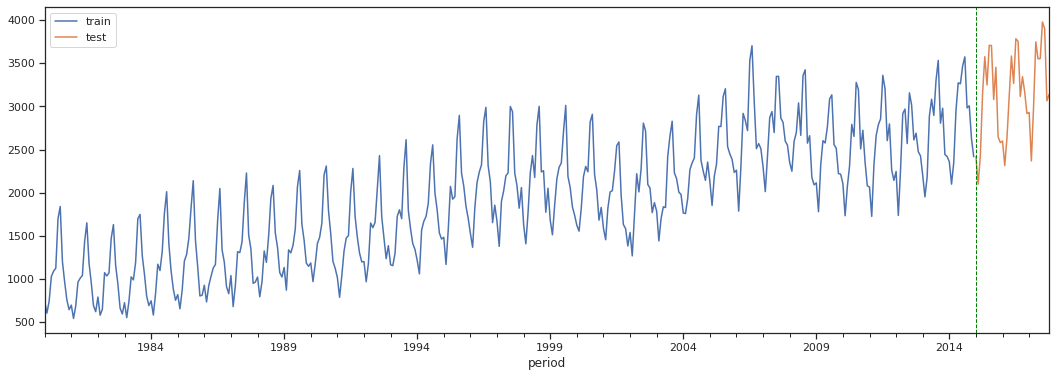

In [8]:
fig, ax = plt.subplots(figsize=(18,6))
#los indices del entregamiento 
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
#los indices del test de validacion 
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/prophet-split.png'); ## recuerda crear la carpeta images si trabajas con Google Colab

# Facebook Prophet Model

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

#### $$X(t) = T(t) + S(t) + H(t) + \varepsilon_t$$

##### <small>$T(t)$ - trend, $S(t)$ - seasonal effects, $H(t)$  - holidays (potentially irregular), $\varepsilon_t$ - unpredicted effects.</small>

#### The seasonality is modeled by the Fourier Series.

### Specifying Seasonalities
Prophet by default can fit weekly and yearly seasonalities, if the time series is more than two cycles long. However, it's possiblIt to add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.

### Holidays and Special Events
Prophet allows to include holidays and other special events. It must include all occurrences of the holiday, both in the past and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

In [9]:
from fbprophet import Prophet

https://en.wikipedia.org/wiki/Tourism_in_the_United_Kingdom

Top 3 countiries visiting UK: FR, US, DE

In [10]:
import holidays

years = range(1980, 2017)

uk_holidays = holidays.UK(years=years)

visitors_holidays = holidays.FRA(years=years) +\
    holidays.US(years=years) +\
    holidays.DE(years=years)

all_holidays = uk_holidays + visitors_holidays

In [11]:
df_holidays = pd.DataFrame.from_dict(all_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

In [14]:
from datetime import date
#puntos de alteracion 
changepoints = {
    date(2001,9,11): "September 11 attacks in the US",
    date(2008,9,15): "Start of the Global Financial Crisis",
    date(2009,8,1): "End of the Global Financial Crisis"
}

In [15]:
#datos de entrenamiento
df_prophet_train = df.loc[train_range][["period", "value"]]
df_prophet_train.columns = ["ds", "y"]
#alimentando el modelo prophet
#consideramos estacionalidad anual, 
model = Prophet(
    yearly_seasonality=True, #verano aire mas limpio
    weekly_seasonality=False, #fds mas contaminados
    daily_seasonality=False, #menos contaminacion a las 15:00-14:00
    changepoints=list(changepoints.keys()),
    holidays=df_holidays,
    mcmc_samples=12, #jugar con este valor de frecuencia porque esto esta en 12 meses
    growth='linear',
    interval_width=0.9)

In [16]:
model.fit(df_prophet_train);

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


## Make prediction

In [17]:
#tomamos los datos de test para hacer predicciones sobre esos datos
df_prophet_test = df.loc[test_range][["period", "value"]]
df_prophet_test.columns = ["ds", "y"]

#modelo de "forecast" "predict", predice con los datos de test
forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = df.loc[test_range].value.values

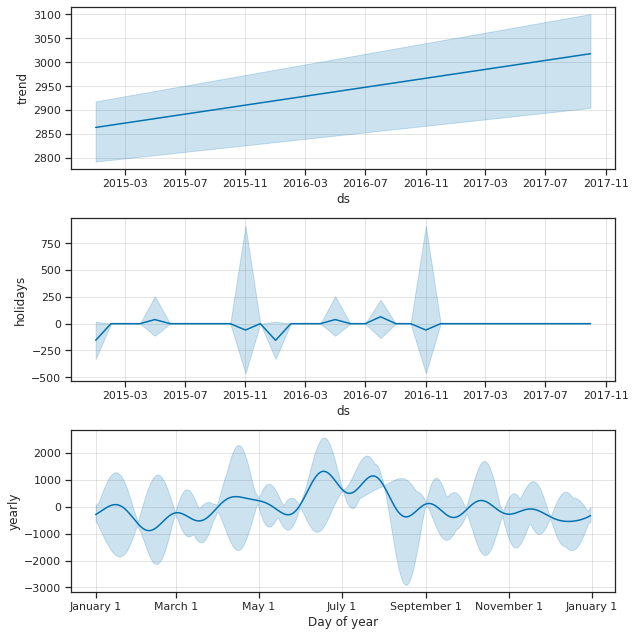

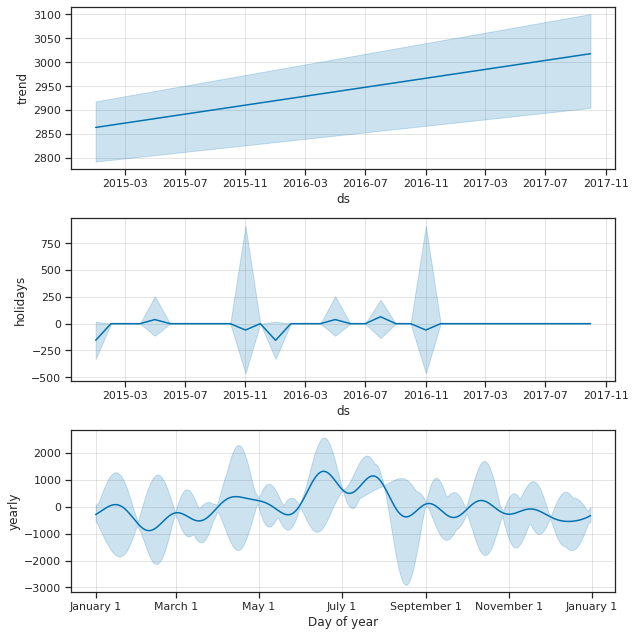

In [ ]:
model.plot_components(forecast)

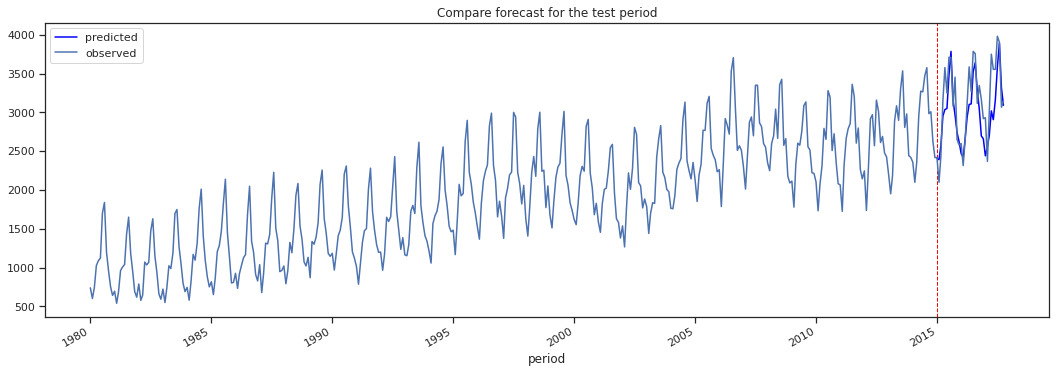

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('images/prophet-forecast-testrange.png')
plt.show();

pronostico: conclusion bastante preciso, el modelo es incapaz de predecir bien algunos detalles, pero funciona bien y necesitamos numeros y metricas por eso hacemos un zoom para ver las diferencias 


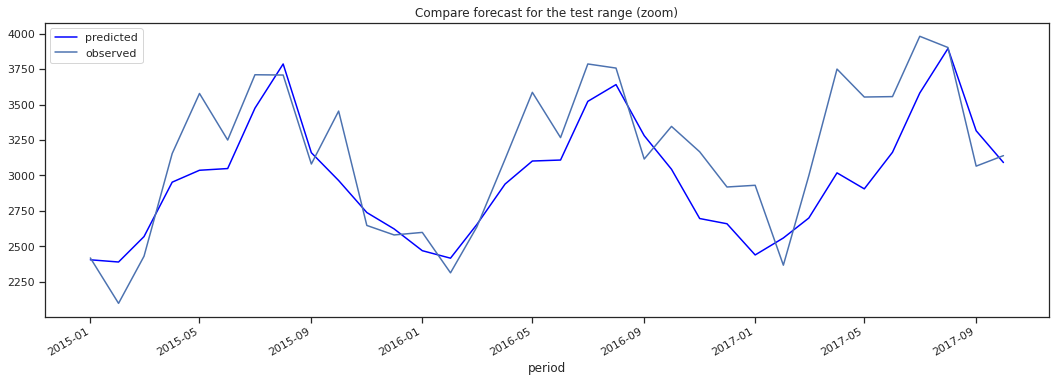

In [19]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('images/prophet-forecast-testrange-zoom.png')
plt.show();

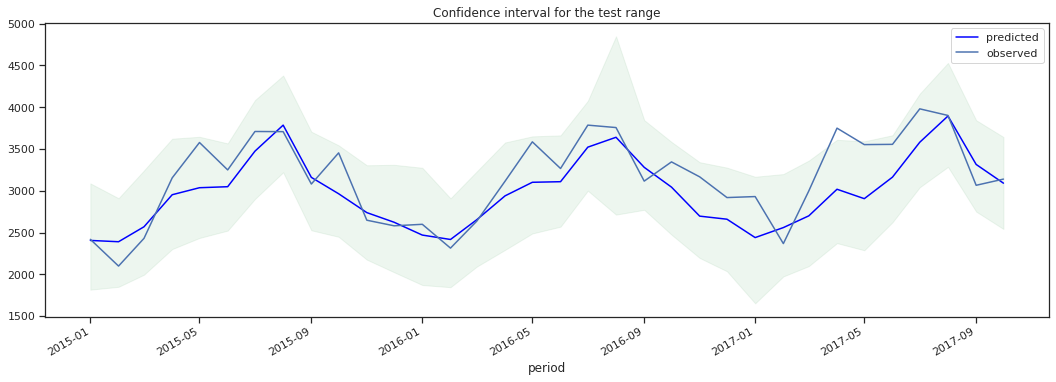

In [20]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('images/prophet-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):

  #medidas de desempeño que necesitamos calcular 
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [23]:
#lo mismo de la teoria pero falta el MAPE el porcetaje de error, 
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 250
MSE (test): 97111
R2  (test): 0.617
U   (test): 0.000033
